# Working with automated computations: Imported tables
# Application to Calcium Imaging

Welcome back! The practical example of this session is Calcium Imaging! 

During this session you will learn:

* To import neuron imaging data from data files into an `Imported` table
* To automatically trigger data importing and computations for all the missing entries with `Populate`

## Importing libraries

First thing first, let's import `DataJoint` again.

In [1]:
import datajoint as dj

As we are going to perform some computations, let's go ahead and import `NumPy` and `Matplotlib`.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Schema, Mouse & Session

We will continue working with the tables that we defined in the previous session. To do so, we will need the classes for each table: `Mouse` and `Session`. 

We can either redefine it here, but for your convenience, we have included the schema and table class definitions in a package called `tutorial_pipeline.mouse_session`, from which you can import the classes as well as the schema object. 

We will use the schema object again to define more tables.

In [3]:
from tutorial_pipeline.mouse_session import schema, Mouse, Session

[2023-07-25 20:54:56,914][INFO]: Connecting root@fakeservices.datajoint.io:3306
[2023-07-25 20:54:56,935][INFO]: Connected root@fakeservices.datajoint.io:3306


Take a quick look at the tables `Mouse` and `Session`:

In [4]:
Mouse()

mouse_id Unique animal ID,dob date of birth,sex sex
0,2017-03-01,M
1,2016-11-19,M
2,2016-11-20,unknown
5,2016-12-25,F
10,2017-01-01,F
11,2017-01-03,F
100,2017-05-12,F


In [6]:
Session()

mouse_id Unique animal ID,session_date date,experiment_setup experiment setup ID,experimenter experimenter name,data_path
0,2017-05-15,0,Edgar Y. Walker,/workspaces/datajoint-tutorials/data
0,2017-05-19,0,Edgar Y. Walker,/workspaces/datajoint-tutorials/data
5,2017-01-05,1,Fabian Sinz,/workspaces/datajoint-tutorials/data
100,2017-05-25,100,Jacob Reimer,/workspaces/datajoint-tutorials/data


The `mouse_session.py` file located in the folder `tutorial_pipeline` also fills each table with example data to make sure that we are all on the same page.

## Scan table and primary key attributes

First we define a table named `Scan` that describes a scanning in an experimental session of Calcium Imaging that will store the meta information of the scans.

In [7]:
@schema
class Scan(dj.Manual):
    definition = """
    -> Session
    scan_idx    : int           # scan index
    ---
    depth       : float         # depth of this scan
    wavelength  : float         # wavelength used
    laser_power : float         # power of the laser used
    fps         : float         # frames per second
    file_name    : varchar(128) # name of the tif file
    """

The table `Scan` is dependent on the table `Session`, inheriting its primary key attributes. In addition, `Scan` has an additional primary key attribute `scan_idx`. 

One session might contain multiple scans - This is another example of **one-to-many** relationship. 

Take a look at the `Diagram` again:

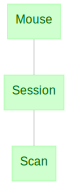

In [8]:
dj.Diagram(schema)

The thin solid line connecting [`Mouse`-`Session`] and [`Session`-`Scan`] indicates **one-to-many relationship**.  

The underline `____` indicates **additional primary key attribute(s)** apart from the ones inherited from its parents.

## Calcium imaging datasets

In the `data` folder in this `DataJoint-Tutorials`, you can find three calcium imaging datasets. Raw data are stored as *.tif* files.

Let's list these three files:

In [9]:
from tutorial_pipeline import data_dir
data_dir

PosixPath('/workspaces/datajoint-tutorials/data')

In [10]:
for f in data_dir.glob('*.tif'):
    print(f)

/workspaces/datajoint-tutorials/data/example_scan_02.tif
/workspaces/datajoint-tutorials/data/example_scan_03.tif
/workspaces/datajoint-tutorials/data/example_scan_01.tif


In [11]:
Scan()

mouse_id Unique animal ID,session_date date,scan_idx scan index,depth depth of this scan,wavelength wavelength used,laser_power power of the laser used,fps frames per second,file_name name of the tif file
0,2017-05-15,1,150.0,920.0,26.0,15.0,example_scan_01.tif
0,2017-05-15,2,200.0,920.0,24.0,15.0,example_scan_02.tif
0,2017-05-15,3,200.0,920.0,24.0,15.0,example_scan_02.tif


Now we manually `insert` the meta information of the datasets and their file names in the table `Scan`:

In [14]:
Scan.insert([
    {'mouse_id': 0, 'session_date': '2017-05-15', 'scan_idx': 1, 
     'depth': 150, 'wavelength': 920, 'laser_power': 26, 'fps': 15, 'file_name': 'example_scan_01.tif'},
    {'mouse_id': 0, 'session_date': '2017-05-15', 'scan_idx': 2, 
     'depth': 200, 'wavelength': 920, 'laser_power': 24, 'fps': 15, 'file_name': 'example_scan_02.tif'},
    {'mouse_id': 0, 'session_date': '2017-05-15', 'scan_idx': 3, 
     'depth': 200, 'wavelength': 920, 'laser_power': 24, 'fps': 15, 'file_name': 'example_scan_03.tif'} 
])

DuplicateError: ("Duplicate entry '0-2017-05-15-1' for key 'scan.PRIMARY'", 'To ignore duplicate entries in insert, set skip_duplicates=True')

In [15]:
Scan()

mouse_id Unique animal ID,session_date date,scan_idx scan index,depth depth of this scan,wavelength wavelength used,laser_power power of the laser used,fps frames per second,file_name name of the tif file
0,2017-05-15,1,150.0,920.0,26.0,15.0,example_scan_01.tif
0,2017-05-15,2,200.0,920.0,24.0,15.0,example_scan_02.tif
0,2017-05-15,3,200.0,920.0,24.0,15.0,example_scan_02.tif


## Looking into the raw data

Let's first load and look at the shape (frames, height and width) of one of the example TIFF of the calcium imaging dataset:

In [18]:
import os
from skimage import io
im = io.imread(data_dir / 'example_scan_01.tif')
print(im.shape)

(100, 128, 128)


Particularly, this example contains 100 frames. 

Let's take the average of the images over frames and look at it.

In [ ]:
# ENTER YOUR CODE! - compute the avg frame with np.mean of axis=0
avg_image = np.mean(im, axis=0)
plt.imshow(avg_image, cmap=plt.cm.gray)

## Defining table for average fluorescence across frames

Now let's create a table `AverageFrame` to compute and save the average fluorescence. 

For each scan, we have one average frame. Therefore, the table shares the exact same primary key as the table `Scan`

In [ ]:
@schema
class AverageFrame(dj.Imported):
    definition = """
    -> Scan
    ---
    average_frame   : longblob     # average fluorescence across frames
    """

Let's check the state of our pipeline.

In [ ]:
dj.Diagram(schema)

Note that `AverageFrame` and `Scan` share the exact same primary key attributes, so `Scan` and `AverageFrame` have a **one-to-one** relationship, which is indicated with a thick solid line.

We defined `average_frame` as a `longblob` so that it can store a NumPy array. This NumPy array will be imported and computed from the file corresponding to each scan.

Note that our `AverageFrame` class inherits from `dj.Imported` instead of `dj.Manual` like others. This is because **this table's content will depend on data imported from an external file**. The `Manual` vs `Imported` are said to specify the **tier of the table**.

## DataJoint table tiers

In DataJoint, the tier of the table indicates **the nature of the data and the data source for the table**. So far we have encountered two table tiers: `Manual` and `Imported`, and we will encounter the two other major tiers in this session. 

DataJoint tables in `Manual` tier, or simply **Manual tables** indicate that its contents are **manually** entered by either experimenters or a recording system, and its content **do not depend on external data files or other tables**. This is the most basic table type you will encounter, especially as the tables at the beggining of the pipeline. In the Diagram, `Manual` tables are depicted by green rectangles.

On the other hand, **Imported tables** are understood to pull data (or *import* data) from external data files, and come equipped with functionalities to perform this importing process automatically, as we will see shortly! In the Diagram, `Imported` tables are depicted by blue ellipses.

In [ ]:
dj.Diagram(schema)

## Importing data into the `Imported` table

Rather than filling out the content of the table manually using `insert1` or `insert` methods, we are going to make use of the `make` and `populate` logic that comes with `Imported` tables to automatically figure out what needs to be imported and perform the import!

## `make` and `populate` methods

`Imported` table comes with a special method called `populate`. Let's try calling it.

In [ ]:
# ENTER YOUR CODE! - call `populate` on the table
AverageFrame.populate()

Notice that `populate` call complained that a method called `make` is not implemented. Let me show a simple `make` method that will help elucidate what this is all about.

In [ ]:
@schema
class AverageFrame(dj.Imported):
    definition = """
    -> Scan
    ---
    average_frame   : longblob     # average fluorescence across frames
    """
    def make(self, key):  # key is the primary key of one of the entries in the table `Scan`
        print('key is', key)

Now, let's call `populate` again!

In [ ]:
# ENTER YOUR CODE! - call `populate` on the table
AverageFrame.populate()

When you call `populate` on an `Imported` table, this triggers DataJoint to look up all tables that the `Imported` table depends on.

For **every unique combination of entries in the depended or "parent" tables**, DataJoint calls `make` function, passing in the primary key of the parent(s).

Because `AverageFrame` depends on `Scan`, `AverageFrame`'s `make` method was called for each entry of `Scan`

In [ ]:
Scan()

Note that `make` only receives the *primary key attributes* of `Scan` (`mouse_id`, `session_date`, `scan_idx`) but not the other attributes.

## Implementing `make`

Now we have a better understanding of `make`, let's implement `make` to perform the importing of data from file.

In [ ]:
import os
@schema
class AverageFrame(dj.Imported):
    definition = """
    -> Scan
    ---
    average_frame   : longblob     # average fluorescence across frames
    """
    def make(self, key):  # key is the primary key of one of the entries in the table `Scan`
        # fetch data directory from table Session
        data_path = (Session & key).fetch1('data_path')
        
        # fetch data file name from table Scan
        file_name = (Scan & key).fetch1('file_name')
        
        # load the file
        im = io.imread(os.path.join(data_path, file_name))
        # compute the average image across the frames
        avg_image = np.mean(im, axis=0)
        
        # Now prepare the entry as a dictionary with all fields defined in the table.
        key['average_frame'] = avg_image # inherit the primary key from the table Scan
        
        # insert entry with the method `insert1()`
        self.insert1(key)
        
        print('\tPopulated Scan {mouse_id} - {session_date} - {scan_idx}'.format(**key))

Notice that we added the missing attribute information `average_frame` into the `key` dictionary, and finally **inserted the entry** into `self` = `AverageFrame` table. The `make` method's job is to create and insert a new entry corresponding to the `key` into this table!

Finally, let's go ahead and call `populate` to actually populate the `AverageFrame` table, filling it with data loaded and computed from data files!

In [ ]:
AverageFrame.populate()

Let's take a look at the table now.

In [ ]:
AverageFrame()

What happens if we call `AverageFrame.populate` again?

In [ ]:
AverageFrame.populate()

That's right - nothing! This makes sense, because we have computed `AverageFrame` for all entries in `Scan` and nothing is left to be computed.

Now what happens if we insert a new entry into `Scan`?

In [ ]:
Scan.insert1({
    'mouse_id': 100,
    'session_date': '2017-05-25',
    'scan_idx': 1,
    'depth': 150,
    'wavelength': 920,
    'laser_power': 25,
    'fps': 15,
    'file_name': 'example_scan_03.tif'
})

We can find all `Scan` without corresponding `AverageFrame` entry with the **negative restriction operator** `-`

In [ ]:
# select all Scan entries *without* a corresponding entry in AverageFrame
Scan - AverageFrame

In [ ]:
AverageFrame.populate()

`populate` found the uncomputed entry and processed it!

In [ ]:
AverageFrame()

Now instead of loading from the raw tif file, we are able fetch the average fluorescence image from this table.

In [ ]:
key = dict(mouse_id=0, session_date='2017-05-15', scan_idx=1)
avg_image = (AverageFrame & key).fetch1('average_frame')
plt.imshow(avg_image, cmap=plt.cm.gray)

## Summary

Congratulations! You have successfully extended your pipeline with a table to represent processed data (`AverageFrame` as `Imported` table), learned and implemented the `make()` and `populate()` call to load external data to your tables.

In [ ]:
dj.Diagram(schema)

At this point, our pipeline contains the core elements with data populated, ready for further downstream analysis.

In the next [session](./03-Computed%20Table,%20Lookup%20Table,%20and%20Part%20Table%20-%20Interactive.ipynb), we are going to introduce the concept of `Computed` table, and `Lookup` table, as well as learning to set up a automated computation routine.